In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from E_model import model, show_plot

In [2]:
num_samples = 200
sigma_big = 0.2
sigma_small = 0.01
p = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]

Yxs_dist = np.random.normal(p[0], sigma_big, num_samples)
qs_max_dist = np.random.normal(p[1], sigma_big, num_samples)
Ks_dist = np.random.normal(p[2], sigma_big, num_samples)
m_s_dist = np.random.normal(p[3], sigma_small, num_samples)
lag_dist = np.random.normal(p[4], sigma_small, num_samples)

df_p = pd.DataFrame({
    'Yxs': Yxs_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist
})
df_p.describe()

,Yxs,qs_max,Ks,m_s,lag
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.431309,1.142154,0.680004,0.009849,0.191850
std,0.218199,0.204105,0.188565,0.010009,0.010156
min,-0.194459,0.641285,0.100625,-0.015061,0.164553
25%,0.276795,1.002158,0.546814,0.002788,0.184959
50%,0.438264,1.141941,0.667849,0.009484,0.191549
75%,0.572083,1.284021,0.813383,0.017134,0.198947
max,1.043026,1.614223,1.151304,0.034605,0.223318


In [3]:
list_p = list(df_p.iloc[0])
list_p

[0.6687498335792039,
 0.9232458200512964,
 1.0842450404487758,
 0.030173303477626826,
 0.1998614191103639]

In [4]:
df_batches = pd.DataFrame(columns=['time', 'biomass', 'glucose', 'batch_id'])
for i in range(df_p.shape[0]):
    batch_id = str(i).zfill(3)
    list_p = list(df_p.iloc[i])
    df = model(list_p)
    df['batch_id'] = str(batch_id)
    # show_plot(df)
    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/generated data/df_gen.csv')

In [9]:
df_gen = pd.read_csv('data/generated data/df_gen.csv')

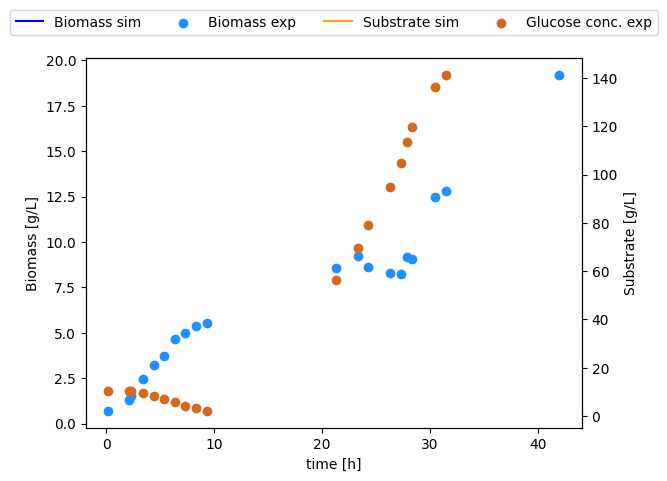

In [10]:
df_one = df[df['batch_id'] == '187']
show_plot(df_one)